<a href="https://colab.research.google.com/github/demirbilek95/NLP_Project/blob/main/guidedLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Guided LDA

In [ ]:
!pip install git+https://github.com/CatalinVoss/GuidedLDA

  Cloning https://github.com/CatalinVoss/GuidedLDA to /tmp/pip-req-build-768mc4tu
  Running command git clone -q https://github.com/CatalinVoss/GuidedLDA /tmp/pip-req-build-768mc4tu
  Created wheel for guidedlda: filename=guidedlda-2.0.0.dev27-cp37-cp37m-linux_x86_64.whl size=2492624 sha256=7cda8624195b671e730b2d77158bb02c0691a425054dc73b0eb24607e847bce3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lcorf7wz/wheels/a4/d5/1c/a4bf220c10fc39992c8af75ee87dc0cdd2c332bf6923b4c5eb
Successfully built guidedlda


In [ ]:
df = pd.read_excel("clean_train.xlsx")
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,onehot_encoded,topic,label_encoded,clean_text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...,"[1, 0, 0, 0, 0, 0]",Computer Science,0,reconstruct subject specific effect map predic...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...,"[1, 0, 0, 0, 0, 0]",Computer Science,0,rotation invariance neuralnetwork rotation inv...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,"[0, 0, 1, 0, 0, 0]",Mathematics,11,spherical polyharmonic poisson kernel polyharm...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...,"[0, 0, 1, 0, 0, 0]",Mathematics,11,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,"[1, 0, 0, 1, 0, 0]",Computer Science & Statistics,8,comparative discrete wavelet transform wavelet...


In [ ]:
import numpy as np
import pandas as pd
import guidedlda
from sklearn.feature_extraction.text import CountVectorizer

# vectorize input
vectorizer = CountVectorizer(analyzer='word', 
                             ngram_range=(1,2), 
                             min_df=30, 
                             max_df=0.3, 
                             stop_words='english')

X = vectorizer.fit_transform(df.clean_text.tolist())

# store lookup structures for convenience
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(X.shape)

(20972, 6014)


In [ ]:
# define topic seeds based on intuition
indicators = {
    'LDA_Computer_Science': ["robot", "complexity", "algorithm","code","graph"],
    'LDA_Physics': ["spin", "material", "physics", "electron", "galaxy","star","optical","temperature"], 
    'LDA_Mathematics': ["prove", "asymtotic", "theorem", "equation", "algebra","mathematic","theory"],
    'LDA_Statistics': ["statistical", "learning", "estimator", "sample", "bayesian","regression","distribution","inference","statistics"],
    'LDA_Biology': ["brain", "gene", 'biological', "protein", "dna","cell","drug","population","food","human"],
    'LDA_Finance': ["market", "volatility", "financial", "stock","portfolio","price", "trading","economic","forecast","risk"]
}

topic_names, seed_topic_list = zip(*indicators.items())
# filter out all words not actually in vocab
seed_topic_list = [[w for w in words if w in set(vocab)] for words in seed_topic_list]
    
# create a mapping {word_id: k}, which we need for the model
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
print(seed_topic_list)

[['robot', 'complexity', 'algorithm', 'code', 'graph'], ['spin', 'material', 'physics', 'electron', 'galaxy', 'star', 'optical', 'temperature'], ['prove', 'theorem', 'equation', 'algebra', 'mathematic', 'theory'], ['statistical', 'learning', 'estimator', 'sample', 'bayesian', 'regression', 'distribution', 'inference'], ['brain', 'gene', 'biological', 'protein', 'dna', 'cell', 'drug', 'population', 'human'], ['market', 'volatility', 'financial', 'stock', 'portfolio', 'price', 'trading', 'economic', 'forecast', 'risk']]


In [ ]:
# define model
model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), 
                            n_iter=1000, 
                            random_state=7, 
                            refresh=50, 
                            alpha=0.5, 
                            eta=0.000001)

# fit the model with seeds
doc_topic = model.fit_transform(X, seed_topics=seed_topics, seed_confidence=10)

# retrieve the word descriptors
n_top_words = 6
topic_word = model.topic_word_
descriptors_guided = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: "{}"'.format(topic_names[i], '" "'.join(topic_words)))
    descriptors_guided.append(' '.join(topic_words[:2]))

INFO:guidedlda:n_documents: 20972
INFO:guidedlda:vocab_size: 6014
INFO:guidedlda:n_words: 1762957
INFO:guidedlda:n_topics: 6
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -17347931
INFO:guidedlda:<50> log likelihood: -14016984
INFO:guidedlda:<100> log likelihood: -13995348
INFO:guidedlda:<150> log likelihood: -13986747
INFO:guidedlda:<200> log likelihood: -13981996
INFO:guidedlda:<250> log likelihood: -13973816
INFO:guidedlda:<300> log likelihood: -13972277
INFO:guidedlda:<350> log likelihood: -13971000
INFO:guidedlda:<400> log likelihood: -13967802
INFO:guidedlda:<450> log likelihood: -13964844
INFO:guidedlda:<500> log likelihood: -13962243
INFO:guidedlda:<550> log likelihood: -13960657
INFO:guidedlda:<600> log likelihood: -13958663
INFO:guidedlda:<650> log likelihood: -13957546
INFO:guidedlda:<700> log likelihood: -13956561
INFO:guidedlda:<750> log likelihood: -13956145
INFO:guidedlda:<800> log likelihood: -13954539
INFO:guidedlda:<850> log likelihood: -13954669
INFO

Topic LDA_Computer_Science: "algorithm" "graph" "time" "optimization" "optimal" "code"
Topic LDA_Physics: "field" "energy" "phase" "state" "high" "spin"
Topic LDA_Mathematics: "mathexpr" "mathexpr mathexpr" "theory" "equation" "space" "function"
Topic LDA_Statistics: "datum" "learning" "distribution" "sample" "estimate" "parameter"
Topic LDA_Biology: "learn" "deep" "image" "task" "neuralnetwork" "network"
Topic LDA_Finance: "network" "datum" "time" "user" "analysis" "information"


Guided LDA provides good results for the first 4 topics (Computer Science, Physics, Mathematics and Statistics). However for the last two topics (Quantitative Biology and Quantitative Finance), it doesn't perform well.It seems like for Quantitative Biology we have Deep Learning. It is most likely due to the having less data for those topics. Therefore LDA can not identify them very well.

In [ ]:
lda_topics = [list(indicators.keys())[label] for label in np.argmax(model.doc_topic_,axis=1)] 
df["lda_topics"] = lda_topics

In [ ]:
def getPercentages(df, topic):
    return round(df[df[topic] == 1].lda_topics.value_counts() / len(df[df[topic] == 1]) * 100,3)

In [ ]:
for topic in target_labels:
    print("\033[1m{}\033[0m".format(topic))
    print(getPercentages(df,topic))
    print("*"*30)

Computer Science
LDA_Finance             29.078
LDA_Biology             27.670
LDA_Computer_Science    22.306
LDA_Statistics          11.857
LDA_Mathematics          7.191
LDA_Physics              1.897
Name: lda_topics, dtype: float64
******************************
Physics
LDA_Physics             76.285
LDA_Finance              8.182
LDA_Mathematics          7.650
LDA_Computer_Science     2.711
LDA_Statistics           2.644
LDA_Biology              2.528
Name: lda_topics, dtype: float64
******************************
Mathematics
LDA_Mathematics         66.358
LDA_Statistics          13.831
LDA_Computer_Science    11.819
LDA_Finance              4.112
LDA_Physics              3.400
LDA_Biology              0.481
Name: lda_topics, dtype: float64
******************************
Statistics
LDA_Statistics          43.450
LDA_Biology             24.453
LDA_Computer_Science    15.924
LDA_Finance             11.583
LDA_Mathematics          3.458
LDA_Physics              1.133
Name: lda_topics

In [ ]:
def plotPie(df, topic,ax):
    topics = (df[df[topic] == 1].lda_topics.value_counts() / len(df[df[topic] == 1]) * 100).index
    values = (df[df[topic] == 1].lda_topics.value_counts() / len(df[df[topic] == 1]) * 100).values
    ax.set_title(topic)
    ax.pie(values, labels = topics,autopct='%1.2f%%')

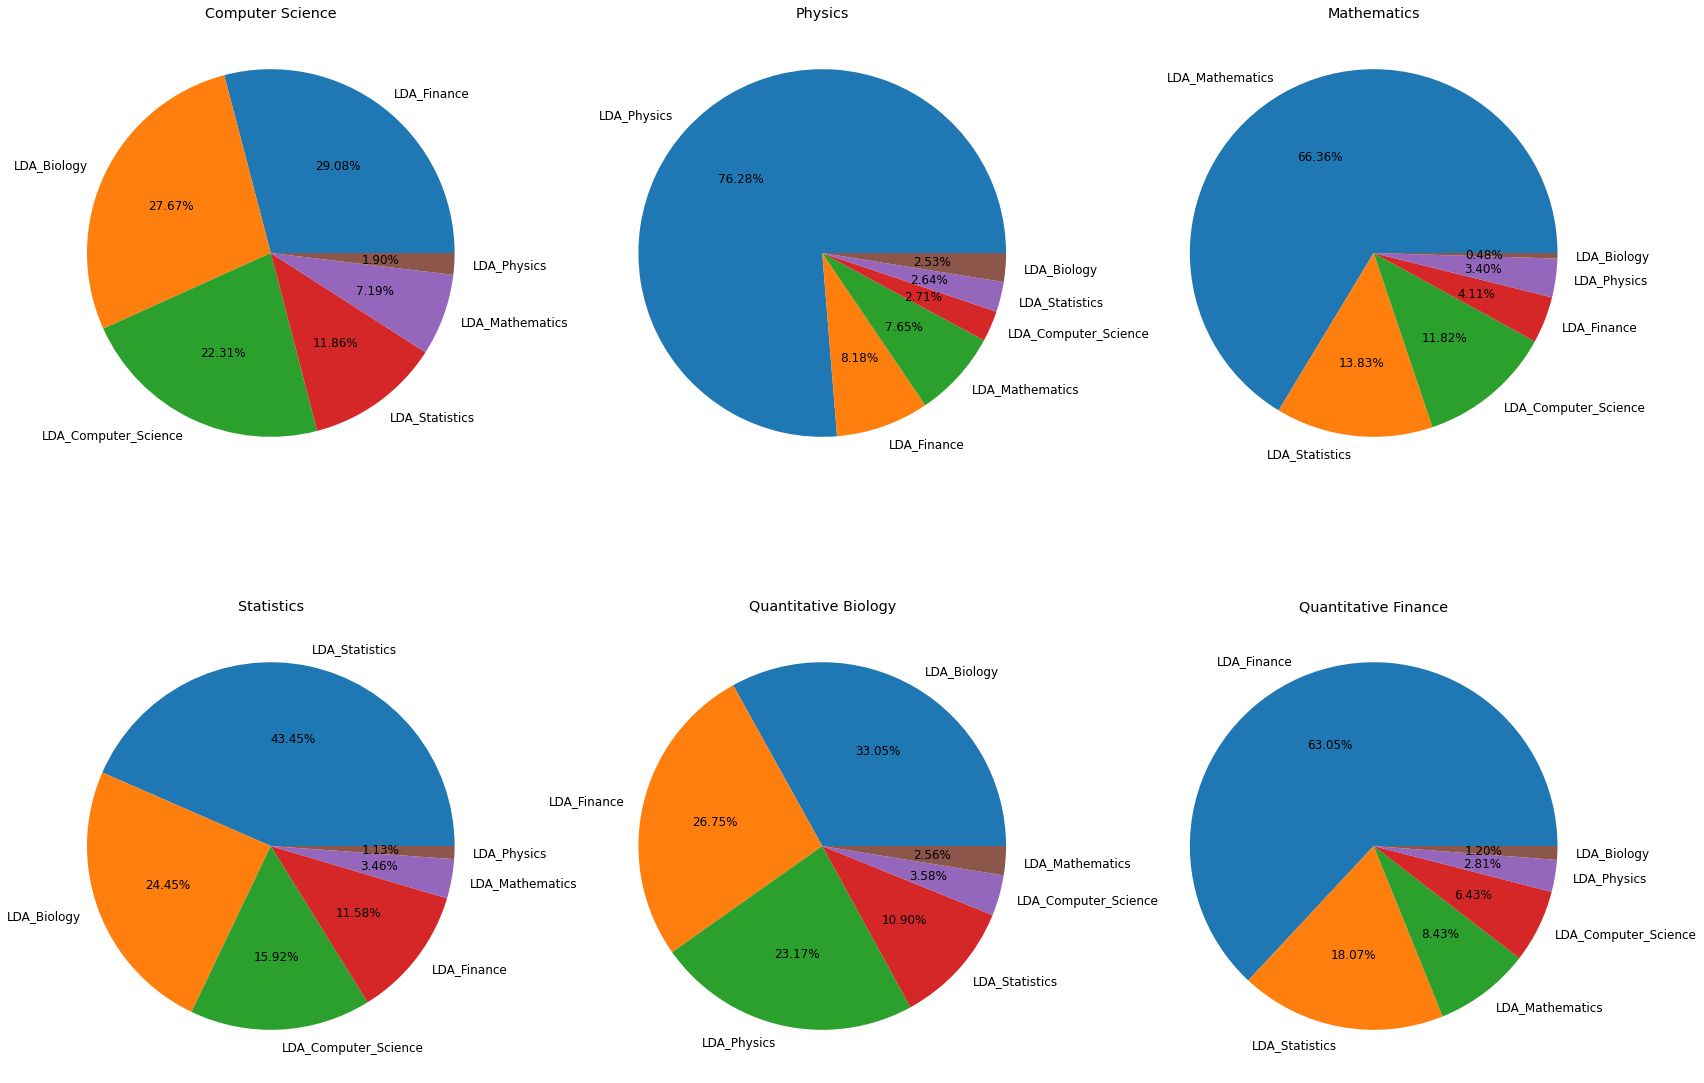

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(28,20))
for ax,topic in zip((ax1, ax2, ax3, ax4, ax5, ax6),target_labels):
    plotPie(df,topic,ax)
    
plt.savefig("ldaTopics.png")